In [1]:
from segment_image import *
from tqdm import tqdm
import pickle

In [2]:
def draw_hough_lines(lines, shape, line_thickness):
    lines_img = np.zeros(shape)
    for l in lines:
        x1 = l[0][0]
        y1 = l[0][1]
        x2 = l[1][0]
        y2 = l[1][1]
        #print(l)
        #print(x1, y1, x2, y2)
        cv2.line(lines_img, (x1,y1), (x2,y2), (255,255,255), line_thickness)

    return lines_img

In [3]:
def potential_staff_lines(note_img_thresh, staff_thickness):
    DEG_TO_RAD = np.pi/180
    width = note_img_thresh.shape[1]

    # Hough to get potential staff lines
    line_length = int(width/4)
    lines = probabilistic_hough_line(note_img_thresh, threshold=10, line_length=line_length, line_gap=3, theta=np.arange(80*DEG_TO_RAD, 100*DEG_TO_RAD, 1*DEG_TO_RAD), seed=40)
    lines_img_before_filteration = draw_hough_lines(lines, note_img_thresh.shape, 1)
    lines_img_before_filteration = cv2.dilate(lines_img_before_filteration, np.ones((1, 11)))

    # Get widest 5 contours/lines
    lines_img = np.copy(lines_img_before_filteration)
    image, contours, hierarchy = cv2.findContours(lines_img_before_filteration.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours_bounding_rectangles = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        #print(x, y, w, h)
        contours_bounding_rectangles.append([c, [x, y, w, h]])

    contours_bounding_rectangles_sorted = sorted(contours_bounding_rectangles, key = lambda x: x[1][2], reverse=True) # sort by width
    contours_widest_5 = []
    j = 5 if len(contours_bounding_rectangles_sorted) >= 5 else len(contours_bounding_rectangles_sorted)
    for i in range(j):
        contours_widest_5.append(contours_bounding_rectangles_sorted[i][0])

    # Draw widest 5 contours/lines
    lines_img = np.zeros(note_img_thresh.shape, dtype=np.uint8)
    lines_img = cv2.cvtColor(cv2.drawContours(gray2rgb(lines_img), contours_widest_5, -1, (255,255,255), 1), cv2.COLOR_BGR2GRAY)
    k = 3
    lines_img = my_close(lines_img, np.ones((k*staff_thickness, k*staff_thickness)))
    lines_img = cv2.dilate(lines_img, np.ones((3, 3)))

    # my_show_images([lines_img])

    return lines_img

In [4]:
def remove_staff_lines(note_img_gray):
    # Otsu's thresholding
    ret, note_img_thresh = cv2.threshold(note_img_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    _distance_between_staves, _staff_thickness = get_distance_between_staves_and_staff_thickness(note_img_thresh)

    note_img_thresh = 255-note_img_thresh

    # Potential staff lines
    potential_lines_img = potential_staff_lines(note_img_thresh, _staff_thickness)
    lines_img_flattened = (potential_lines_img > 128).T.flatten()
    
    # Iterate over each column to remove any "run of white pixels" with a length of "m*_staff_thickness"
    # But it must be a part from a potentail line to confirm removing (potential lines calculated above)
    note_img_thresh_flattened = (note_img_thresh).T.flatten()
    image, contours, hierarchy = cv2.findContours((note_img_thresh_flattened).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        if c.shape == (2, 1, 2):
            p1 = c[1][0][1]
            p0 = c[0][0][1]
            m = 1.55
            if p1 - p0 <= _staff_thickness*m:
                #print(c)
                staff_pixel_percentage = lines_img_flattened[p0:p1+1].sum() / len(lines_img_flattened[p0:p1+1])
                if staff_pixel_percentage > 0.35:
                    note_img_thresh_flattened[p0:p1+1] = 0
        elif c.shape == (1, 1, 2):
            #print(c)
            p0 = c[0][0][1]
            staff_pixel_percentage = lines_img_flattened[p0:p0+1].sum() / len(lines_img_flattened[p0:p0+1])
            if staff_pixel_percentage > 0.35:
                note_img_thresh_flattened[p0:p0+1] = 0


    staff_lines_removed = note_img_thresh_flattened.reshape(note_img_thresh.T.shape).T
    #print(staff_lines_removed.max())

    #my_show_images([note_img_gray, note_img_thresh, potential_lines_img, staff_lines_removed], dpi=80, row_max=5)

    return staff_lines_removed, potential_lines_img, _distance_between_staves, _staff_thickness

In [5]:
def getNotes(original_img, img_thresh):

    #ori_img = io.imread(pathImage)

    width= original_img.shape[1]
    height = original_img.shape[0]

    #img_thresh = ori_img
    #show_images([img_thresh],["thresh"])

    hist = []

    # get Concentration Histogram
    for x in range(width):
        hist.append(sum(img_thresh[0:height,x] == 0))

    # find thr for detecting character
    counts = np.bincount(np.array(hist))
    thr_character = np.argmax(counts) * 1.1



    #convert list of hist to numpy array as uint8 for  using in countours
    a = np.zeros(img_thresh.shape)
    arr = np.array(hist)
    a = a < ((arr > thr_character)*255)
    a = a.astype('uint8')

    #my_show_images([a])

    #a = cv2.dilate(a, np.ones((1, 27)))

    # using a that represnts hist list in countours
    contours, hierarchy = cv.findContours(a, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[-2:]
    listOfImages = []
   
    for contour in contours:

        x, y, w, h = cv.boundingRect(contour)
       
        out = original_img[y:y+h,x:x+w]
        listOfImages.append(out)
        
    return listOfImages    

In [6]:
def add_padding(img_gray, ww, hh, color):
    ht, wd = img_gray.shape[:2]

    # create new image of desired size and color (blue) for padding
    result = np.full((hh, ww), color, dtype=np.uint8)

    # compute center offset
    xx = (ww - wd) // 2
    yy = (hh - ht) // 2

    # copy img image into center of result image
    result[yy:yy+ht, xx:xx+wd] = img_gray

    return result

In [7]:
def contours_mask(contours, shape):
    mask = cv2.cvtColor(np.zeros(shape[:2], dtype=np.uint8), cv2.COLOR_GRAY2BGR)
    mask = cv2.drawContours(mask, contours, -1, (255, 255, 255), -1)
    return cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

In [47]:
def zoom_in(staff_lines_removed, potential_staff_lines):
    notes_masked_only = []
    notes_zoomed_in = []
    staff_lines = []
    notes_contours = []


    staff_lines_removed = np.ascontiguousarray(staff_lines_removed)
    test_copy = cv2.dilate(staff_lines_removed, np.ones((5, 5)))
    #test_copy = staff_lines_removed

    image, contours, hierarchy = cv2.findContours(test_copy,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    #contours_drawn = gray2rgb(np.copy(test_copy))
    contours_sorted_by_area = sorted(contours, key=cv2.contourArea, reverse=True)
    
    max_area_contour = contours_sorted_by_area[0]
    x, y, w, h = cv2.boundingRect(max_area_contour)
    a0 = w*h

    max_area_contour_mask = contours_mask([max_area_contour], staff_lines_removed.shape)
    #my_show_images([staff_lines_removed, max_area_contour_mask], dpi=80, row_max=2)
    masked_biggest = np.copy((staff_lines_removed * (max_area_contour_mask > 128)))
    zoomed_in_biggest = np.copy((staff_lines_removed * (max_area_contour_mask > 128))[y:y+h, x:x+w])
    
    if len(contours_sorted_by_area) == 1:
        # Append zoomed_in_biggest only
        notes_masked_only.append(masked_biggest)
        notes_zoomed_in.append(zoomed_in_biggest)
        staff_lines.append(potential_staff_lines)
        notes_contours.append(max_area_contour)
    else:
        second_max_area_contour = contours_sorted_by_area[1]
        x1, y1, w1, h1 = cv2.boundingRect(second_max_area_contour)
        a1 = w1*h1
        
        if a1 / a0 > 0.4:
            second_max_area_contour_mask = contours_mask([second_max_area_contour], staff_lines_removed.shape)
            masked_second_biggest = np.copy((staff_lines_removed * (second_max_area_contour_mask > 128)))
            zoomed_in_second_biggest = np.copy((staff_lines_removed * (second_max_area_contour_mask > 128))[y1:y1+h1, x1:x1+w1])

            # Append zoomed_in_biggest & zoomed_in_second_biggest in correct order
            if x > x1:
                # Append zoomed_in_biggest first
                notes_masked_only.append(masked_biggest)
                notes_zoomed_in.append(zoomed_in_biggest)
                staff_lines.append(potential_staff_lines)
                notes_contours.append(max_area_contour)

                notes_masked_only.append(masked_second_biggest)
                notes_zoomed_in.append(zoomed_in_second_biggest)
                staff_lines.append(potential_staff_lines)
                notes_contours.append(second_max_area_contour)
            else:
                # Append zoomed_in_biggest second
                notes_masked_only.append(masked_second_biggest)
                notes_zoomed_in.append(zoomed_in_second_biggest)
                staff_lines.append(potential_staff_lines)
                notes_contours.append(second_max_area_contour)
                
                notes_masked_only.append(masked_biggest)
                notes_zoomed_in.append(zoomed_in_biggest)
                staff_lines.append(potential_staff_lines)
                notes_contours.append(max_area_contour)
        else:
            # Append zoomed_in_biggest only
            notes_masked_only.append(masked_biggest)
            notes_zoomed_in.append(zoomed_in_biggest)
            staff_lines.append(potential_staff_lines)
            notes_contours.append(max_area_contour)

    #print(len(notes_masked_only), len(notes_zoomed_in), len(staff_lines), len(notes_contours))
    return notes_masked_only, notes_zoomed_in, staff_lines, notes_contours

In [120]:
def get_note_heads_contours(staff_lines_removed_masked, distance_between_staves, staff_thickness):
    thresh = cv2.adaptiveThreshold(255-staff_lines_removed_masked, 256, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 1)
    thresh = my_open(thresh, np.ones((round(staff_thickness*3.5), round(staff_thickness*3.5))))
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    '''my_area = thresh.shape[0]*thresh.shape[0]
    contours_filtered = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        a = w*h
        print(a/my_area)
        if 0.003 < a/my_area < 0.025: # test 1
            if x > 0 and x+w < thresh.shape[1]: # test 2
                (xc,yc), (d1,d2), angle = cv2.fitEllipse(c)
                major_axis, minor_axis = max(d1,d2), min(d1,d2)
                if major_axis/minor_axis <= 2.2: # test 3
                    epsilon = 0.02*cv2.arcLength(c, True)
                    approx = cv2.approxPolyDP(c, epsilon, True)
                    if len(approx) > 4: # test 4
                        contours_filtered.append(c)'''

    my_area = np.pi/4 * distance_between_staves**2
    contours_filtered = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        a = cv2.contourArea(c)
        print(a, my_area)
        if my_area*0.5 < a < my_area*3: # test 1
            (xc,yc), (d1,d2), angle = cv2.fitEllipse(c)
            major_axis, minor_axis = max(d1,d2), min(d1,d2)
            if major_axis/minor_axis <= 2.2: # test 2
                #if x > 0 and x+w < thresh.shape[1]: # test 3
                    '''epsilon = 0.02*cv2.arcLength(c, True)
                    approx = cv2.approxPolyDP(c, epsilon, True)
                    if len(approx) > 4: # test 4'''
                contours_filtered.append(c)

    contours_drawn = gray2rgb(np.copy(thresh))
    contours_drawn = cv2.drawContours(contours_drawn, contours_filtered, -1, (255, 0, 0), 2)
    #contours_drawn = cv2.drawContours(contours_drawn, contours[2], -1, (255, 0, 0), 2)


    #mask = cv2.dilate(contours_mask(contours_filtered, thresh.shape), np.ones((3, 3)))
    mask = contours_mask(contours_filtered, thresh.shape)
    image, contours_final, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(len(contours_final))

    my_show_images([thresh, contours_drawn, mask], dpi=80, row_max=3)
    return contours_final

### Classifier functions

In [10]:
def extract_hog_features(img):
    """
    TODO
    You won't implement anything in this function. You just need to understand it 
    and understand its parameters (i.e win_size, cell_size, ... etc)
    """
    img = cv2.resize(img, target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

In [11]:
def extract_features(img, feature_set='hog'):
    """
    TODO
    Given either 'hog', 'raw', call the respective function and return its output
    """
    if feature_set == 'hog':
        return extract_hog_features(img)
    elif feature_set == 'raw':
        return extract_raw_pixels(img)

In [12]:
def extract_features_for_all(imgs, feature_set='hog'):
    features = []

    for i, img in enumerate(tqdm(imgs)):
        try:
            features.append(extract_features(img, feature_set))
        except:
            print(img)
            del labels[i]
    
    return features

## identify note letter

In [13]:
def get_letter(staff_lines_img_original,note_contour,distance_between_stave,is_upper):
    x, y, w, h = cv2.boundingRect(note_contour)
    #print(str(x+w)+" vv "+str(y+h))
    staff_lines_img = staff_lines_img_original > 0
    middle = round(x + w/2)
    #height = staff_lines_img.shape[1]
    
    middle_column = staff_lines_img[:,middle]
    
    stave_height_list = [0,0,0,0,0]
   
    last_taken = False
    start_of_line = -1
    array_of_lines =  []
    for i in range(len(middle_column)):
        if(start_of_line!=-1 and middle_column[i]!=1):
            array_of_lines.append((start_of_line+i-1)//2)
            start_of_line = -1
            continue
        
        if(middle_column[i]==1 and start_of_line==-1):
            start_of_line = i 
            continue
        
    
    for i in range(5):
        if(i>=len(array_of_lines)):
            break
        stave_height_list[i]  = array_of_lines[i]
    
    #print(stave_height_list)
    note_place = 0 
    
    if(is_upper):
        note_place = y + distance_between_stave/2
    else:
        note_place = y + h - distance_between_stave/2
    
    #print("note place : "+str(note_place))
#notes = {
#    "c1" : stave_height_list[4]+distance_between_stave,
#    "d1" : stave_height_list[4]+distance_between_stave/2 ,
#    "e1" : stave_height_list[4],
#    "f1" : stave_height_list[3]+distance_between_stave/2,
#    "g1" : stave_height_list[3],
#    "a1" : stave_height_list[2]+distance_between_stave/2,
#    "b1" : stave_height_list[2] ,
#    
#    "c2" : stave_height_list[1]+distance_between_stave/2 ,
#    "d2" : stave_height_list[1] ,
#    "e2" : stave_height_list[0]+distance_between_stave/2 ,
#    "f2" : stave_height_list[0] ,
#    "g2" : stave_height_list[0]-distance_between_stave/2  ,
#    "a2" : stave_height_list[0]-distance_between_stave      
#}
    notes = {
    "c1" : stave_height_list[4]+distance_between_stave,
    "d1" : stave_height_list[4]+distance_between_stave/2 ,
    "e1" : stave_height_list[4],
    "f1" : (stave_height_list[3]+stave_height_list[4])/2,
    "g1" : stave_height_list[3],
    "a1" : (stave_height_list[2]+stave_height_list[3])/2,
    "b1" : stave_height_list[2] ,
    
    "c2" : (stave_height_list[1]+stave_height_list[2])/2 ,
    "d2" : stave_height_list[1] ,
    "e2" : (stave_height_list[0]+stave_height_list[1])/2 ,
    "f2" : stave_height_list[0] ,
    "g2" : stave_height_list[0]-distance_between_stave/2  ,
    "a2" : stave_height_list[0]-distance_between_stave      
}
    min_dist = 10000000
    note = "a1"
    for key, value in notes.items():
        distance = abs(note_place-value)
        #print(key+"  "+str(distance))
        if distance < min_dist :
            min_dist = distance
            
            note = key
    #print(note_place)
    return note

In [14]:
#print(distance_between_staves)
#kk = 10
#print(get_letter()
##174

#my_show_images([list_of_notes_classification_ready[0][kk],list_of_notes_staff_lines_classification_ready[0][kk]])

In [15]:
upper  = {
    "sixtheenth_note" : False ,
    "eighth_note" : False ,
    "thirty_second_note" : False ,
    "quarter_note" : False ,
    "half_note" : False ,
    "whole_note" : False,
    "sixtheenth_note_upside_down" : True ,
    "eighth_note_upside_down" : True ,
    "thirty_second_note_upside_down" : True ,
    "quarter_note_upside_down" : True ,
    "half_note_upside_down" : True 
}

check_for_char  = {
    "sixtheenth_note" : True ,
    "eighth_note" : True ,
    "thirty_second_note" : True ,
    "quarter_note" : True ,
    "half_note" : True ,
    "whole_note" : True,
    "sixtheenth_note_upside_down" : True ,
    "eighth_note_upside_down" : True ,
    "thirty_second_note_upside_down" : True ,
    "quarter_note_upside_down" : True ,
    "half_note_upside_down" : True,
    "augmentation_dot" :False ,
    "double_flat_accidental" :False ,
    "double_sharp_accidental" : False ,
    "flat_accidental":False ,
    "natural_accidental" :False,
    "sharp_accidental" : False ,
    "time_signature_4_2":False ,
    "time_signature_4_4": False,
    "treple_clef":False
}

corresponding_text  = {
    "sixtheenth_note" : "/16" ,
    "eighth_note" : "/8" ,
    "thirty_second_note" : "/32" ,
    "quarter_note" : "/4" ,
    "half_note" : "/2" ,
    "whole_note" : "/1",
    "sixtheenth_note_upside_down" :"/16" ,
    "eighth_note_upside_down" : "/8" ,
    "thirty_second_note_upside_down": "/32" ,
    "quarter_note_upside_down" :  "/4" ,
    "half_note_upside_down" : "/2" ,
    "augmentation_dot" :".",
    "double_flat_accidental" :"&&" ,
    "double_sharp_accidental" : "##" ,
    "flat_accidental":"&" ,
    "natural_accidental" : "",
    "sharp_accidental" : "#",
    "time_signature_4_2": "\meter<\"4/2\">",
    "time_signature_4_4": "\meter<\"4/4\">",
    "treple_clef":""
}

# Load our classifier

In [16]:
target_img_size = (32, 32)
with open('svm.pkl', 'rb') as fid:
    model = pickle.load(fid)

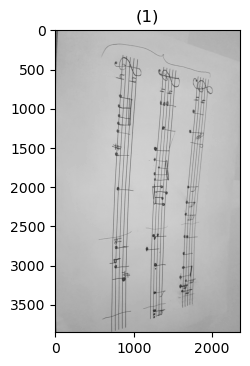

In [104]:
img = my_imread_gray('13.jpg')
my_show_images([img], dpi=100)

# Separate lines

In [105]:
gray_lines, binary_lines, distance_between_staves, staff_thickness = get_lines(img)

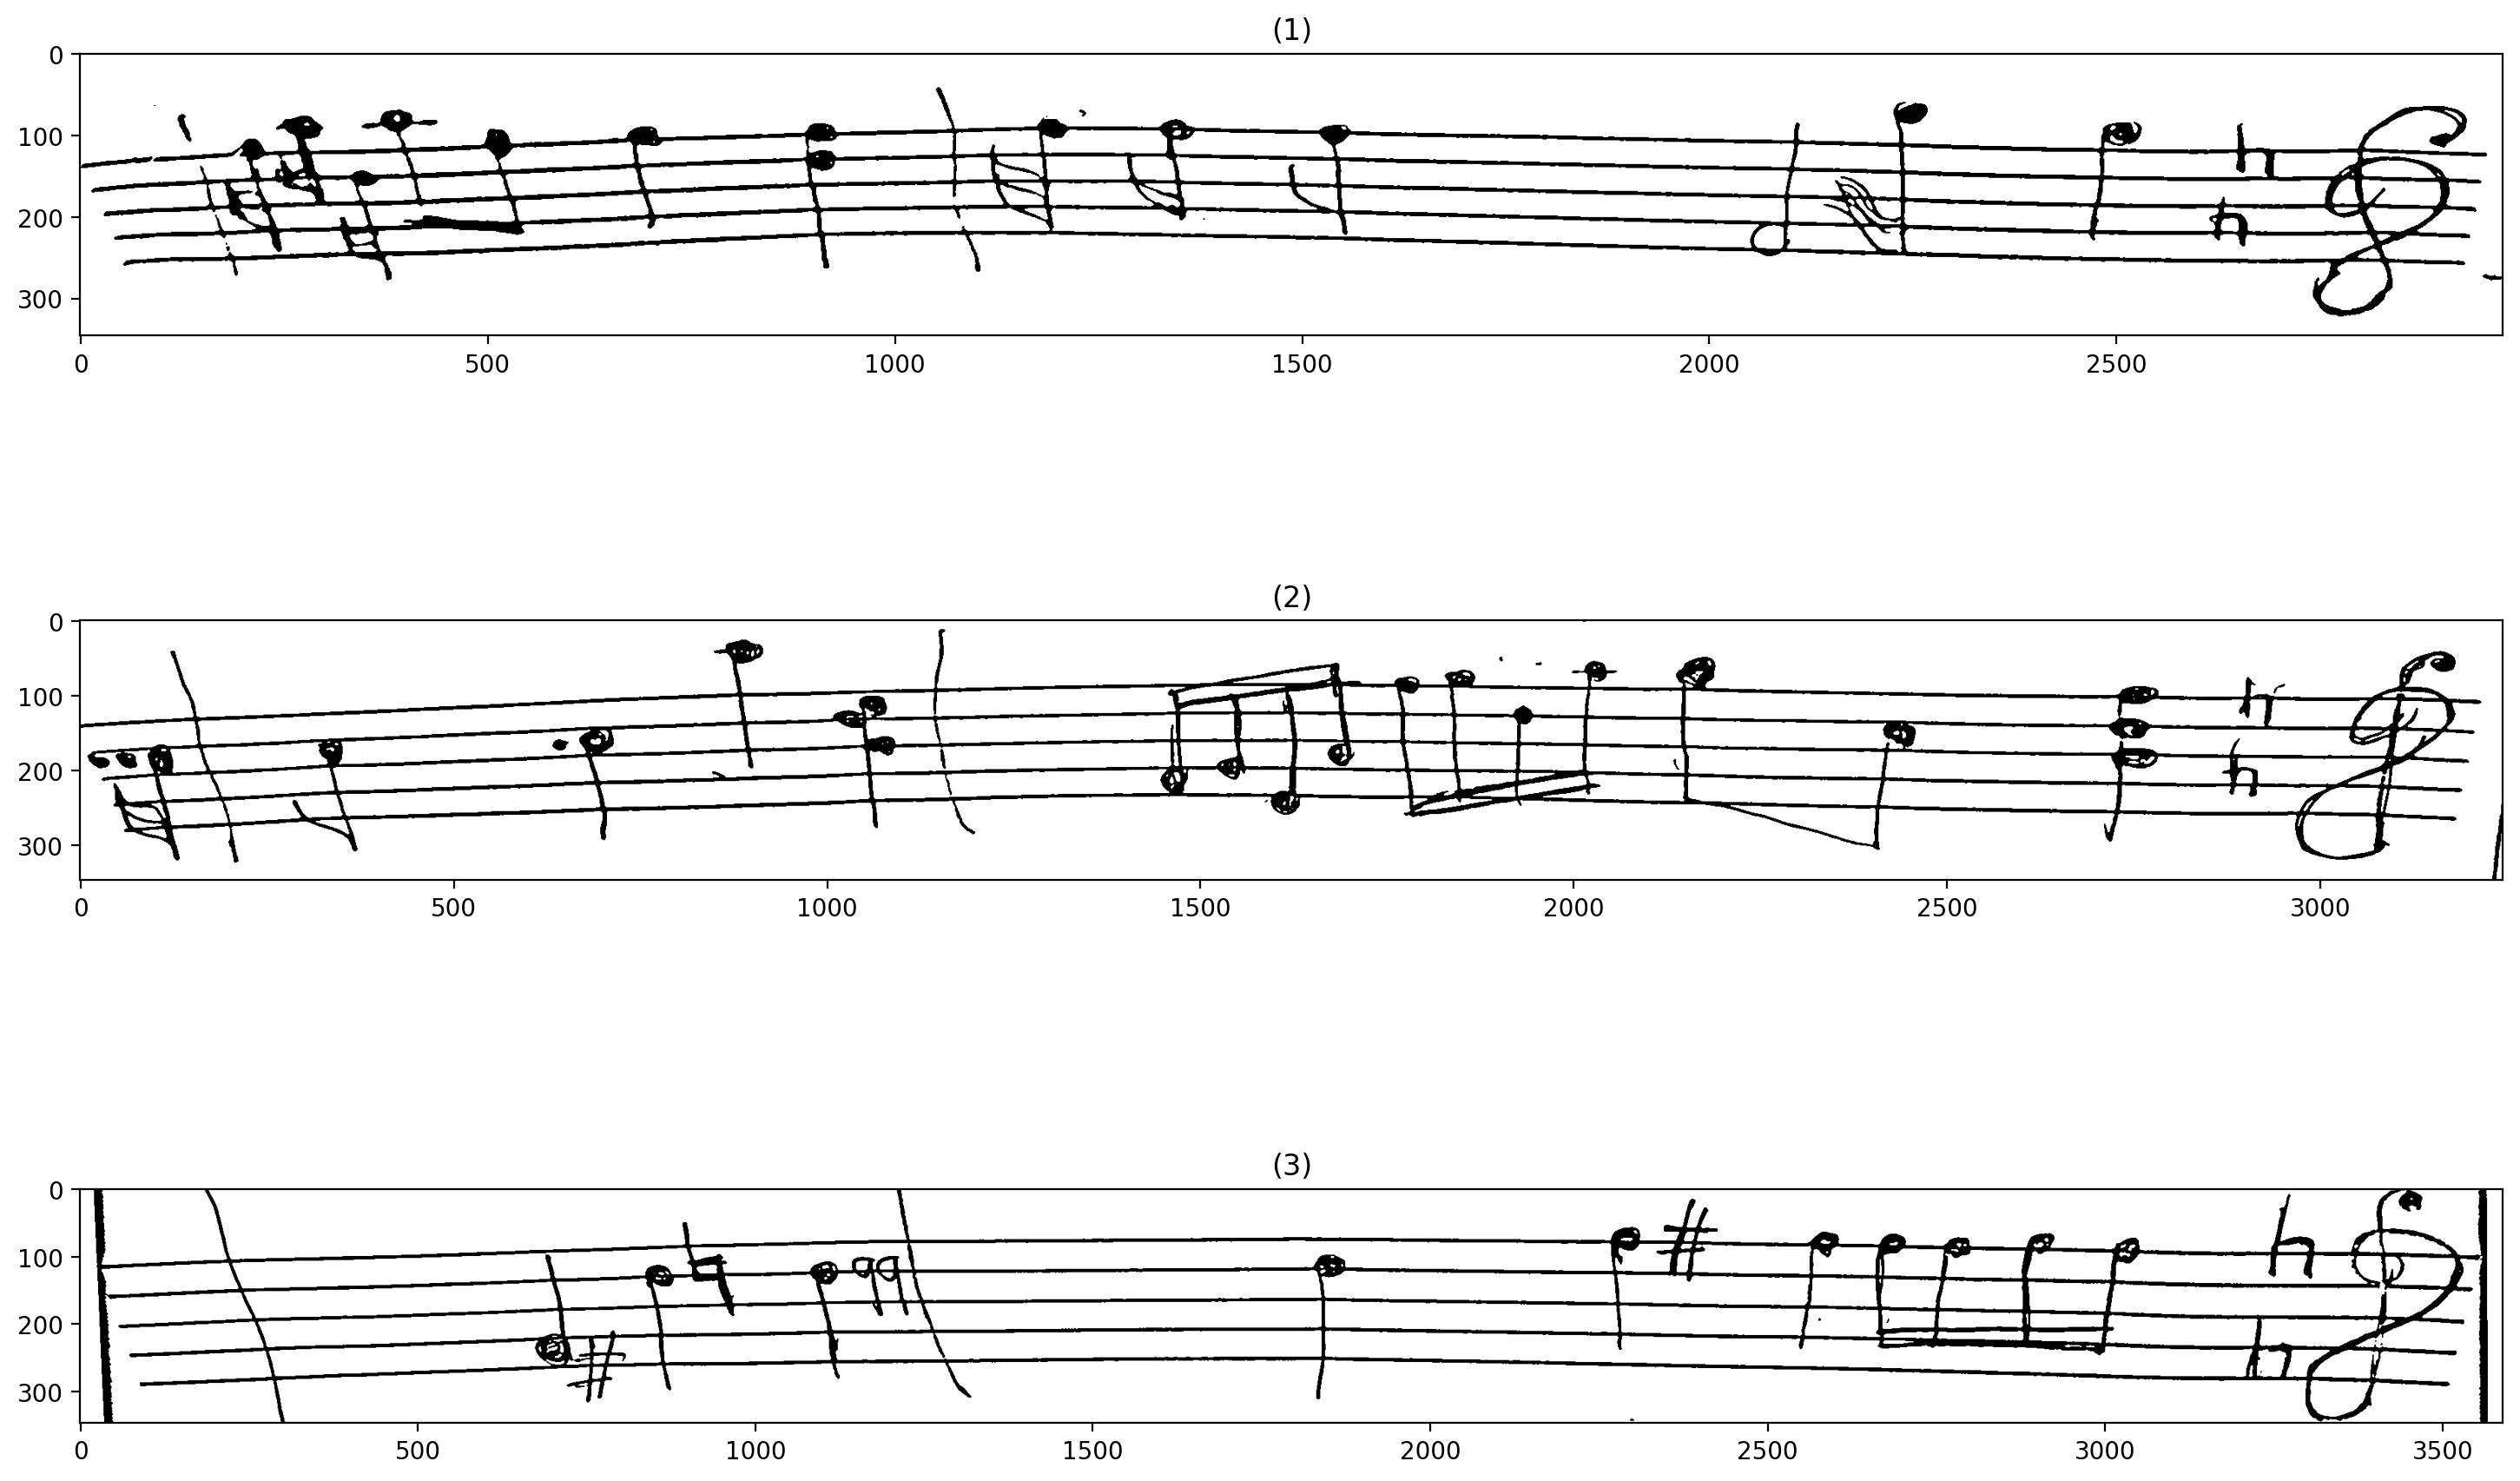

In [106]:
my_show_images(binary_lines, dpi=200)

# Shubra's potential_lines_of_notes 

In [107]:
potential_lines_of_notes = []
for _gray_line, _binary_line in zip(gray_lines, binary_lines):
    potential_lines_of_notes.append(getNotes(_gray_line, _binary_line))

# Removing staff lines

In [108]:
list_of_notes = []
list_of_notes_staff_lines = []
list_of_notes_staff_lines_d_t = []
for i, l in enumerate(potential_lines_of_notes):
    list_of_notes.append([])
    list_of_notes_staff_lines.append([])
    list_of_notes_staff_lines_d_t.append([])
    for _note in l:
        if _note.shape[1] >= 30:
            staff_lines_removed, staff_lines, d, t = remove_staff_lines(_note)
            if (staff_lines_removed > 128).any():
                list_of_notes[i].append(staff_lines_removed)
                list_of_notes_staff_lines[i].append(staff_lines)
                list_of_notes_staff_lines_d_t[i].append((d, t))

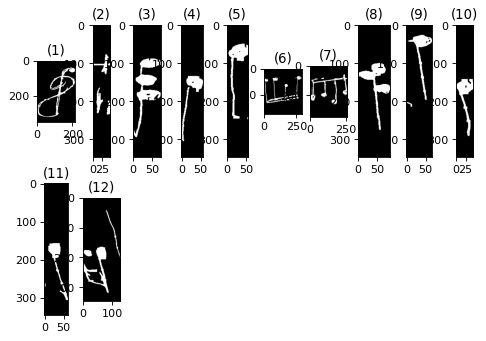

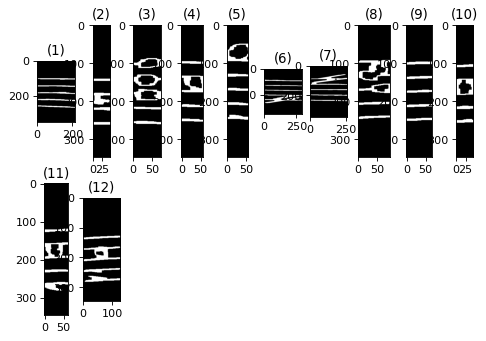

In [109]:
my_show_images(list_of_notes[1], dpi=80, row_max=10)
my_show_images(list_of_notes_staff_lines[1], dpi=80, row_max=10)

# Zoom in

In [110]:
list_of_notes_masked = []
list_of_notes_classification_ready = [] # zoomed in + padding
list_of_notes_classification_ready_split_notes_i = [] # VIP when detecting an upside down treple clef
list_of_notes_staff_lines_classification_ready = []
list_of_notes_classification_ready_contours = []

i = 0
for line_of_notes, line_notes_staff_lines in zip(list_of_notes, list_of_notes_staff_lines):
    list_of_notes_masked.append([])
    list_of_notes_classification_ready.append([])
    list_of_notes_classification_ready_split_notes_i.append([])
    list_of_notes_staff_lines_classification_ready.append([])
    list_of_notes_classification_ready_contours.append([])
    
    split_i = 0
    for note, sl in zip(line_of_notes, line_notes_staff_lines):
        masked, notes, staff_lines, notes_contours = zoom_in(note, sl)
        added_notes = 0
        for m, n, s, c in zip(masked, notes, staff_lines, notes_contours):
            if n.shape[1] >= 25 and n.shape[0] >= 25:
                added_notes += 1
                
                list_of_notes_masked[i].append(m)

                w, h = n.shape[1], n.shape[0]
                aspect_ratio = n.shape[1]/n.shape[0]
                n_padding = add_padding(n, ww=int(w+40/aspect_ratio), hh=int(h+h*aspect_ratio), color=0)
                
                list_of_notes_classification_ready[i].append(n_padding)
                list_of_notes_staff_lines_classification_ready[i].append(s)
                list_of_notes_classification_ready_contours[i].append(c)

        if added_notes == 1:
            list_of_notes_classification_ready_split_notes_i[i].append(-1)
        elif added_notes > 1:
            for j in range(added_notes):
                list_of_notes_classification_ready_split_notes_i[i].append(split_i)
            split_i += 1

    i += 1
    
print(len(list_of_notes_masked[1]), len(list_of_notes_classification_ready[1]))

13 13


In [111]:
features = extract_features_for_all(list_of_notes_classification_ready[2], 'hog')
model.predict(features)

100%|██████████| 14/14 [00:00<00:00, 2187.87it/s]


array(['double_sharp_accidental', 'double_sharp_accidental',
       'quarter_note_upside_down', 'double_sharp_accidental', 'bar_line',
       'bar_line', 'quarter_note_upside_down', 'quarter_note_upside_down',
       'bar_line_thick', 'bar_line', 'sixtheenth_note_upside_down',
       'bar_line', 'quarter_note_upside_down', 'quarter_note'],
      dtype='<U30')

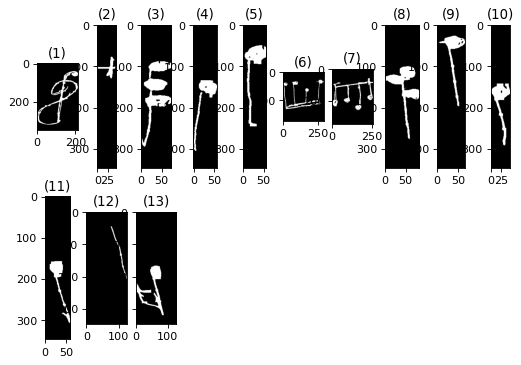

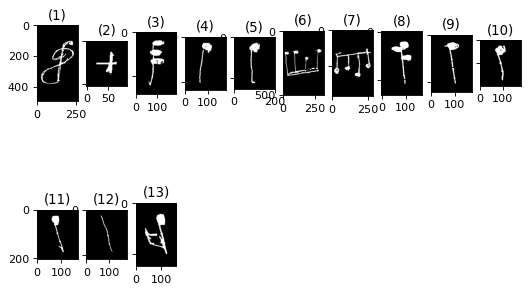

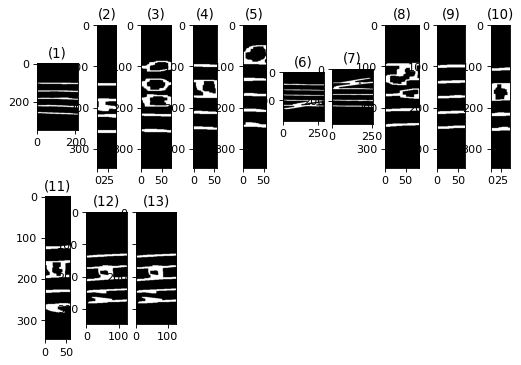

In [112]:
my_show_images(list_of_notes_masked[1], dpi=80, row_max=10)
my_show_images(list_of_notes_classification_ready[1], dpi=80, row_max=10)
my_show_images(list_of_notes_staff_lines_classification_ready[1], dpi=80, row_max=10)

# Detecting note heads

3723.5 660.519855417254
873.5 660.519855417254
6457.5 660.519855417254
12.0 660.519855417254
22730.5 660.519855417254
22232.0 660.519855417254


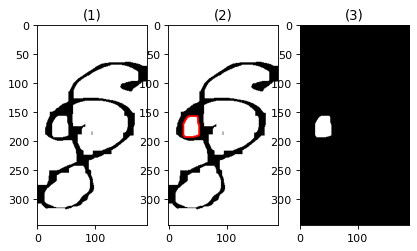

10488.5 660.519855417254
5515.0 660.519855417254


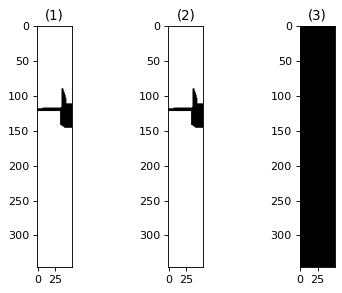

6046.0 660.519855417254
9451.5 660.519855417254


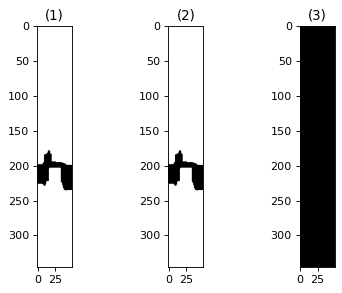

13124.0 660.519855417254
497.5 660.519855417254
6646.5 660.519855417254


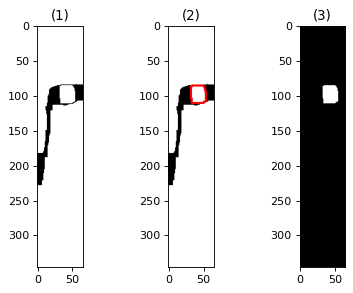

530.5 660.519855417254
17325.5 660.519855417254
466.0 660.519855417254
15799.5 660.519855417254


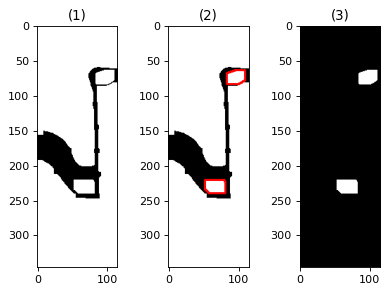

726.5 660.519855417254
7392.0 660.519855417254
330.0 660.519855417254
3361.0 660.519855417254


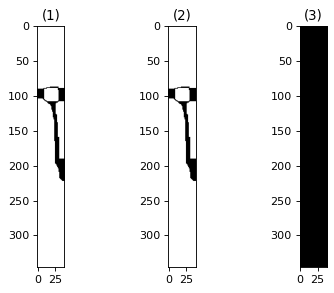

12511.5 660.519855417254
1228.0 660.519855417254
10278.5 660.519855417254


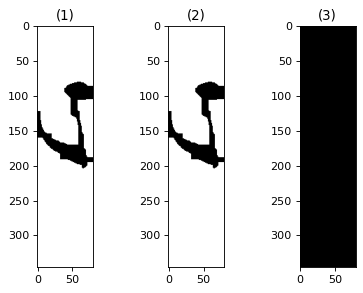

1880.0 660.519855417254
16030.5 660.519855417254
458.0 660.519855417254
10849.0 660.519855417254


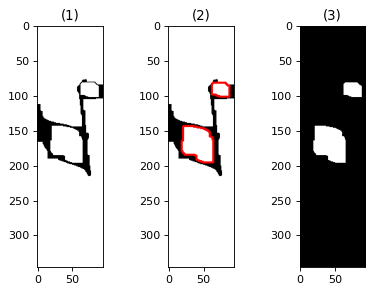

6536.5 660.519855417254
583.0 660.519855417254
469.0 660.519855417254
3184.0 660.519855417254


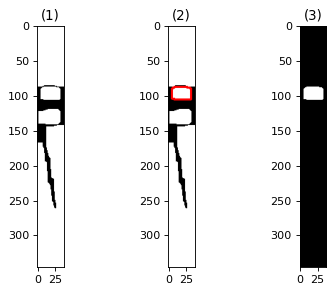

1710.5 660.519855417254
9004.5 660.519855417254
564.0 660.519855417254
4609.5 660.519855417254


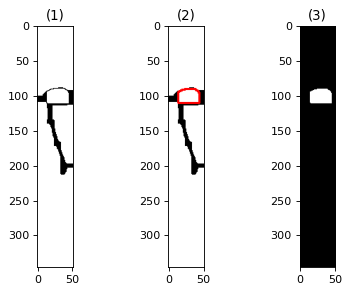

81420.0 660.519855417254
5395.0 660.519855417254
650.0 660.519855417254


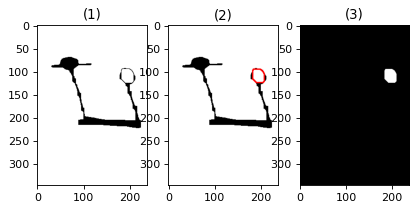

8160.5 660.519855417254
19776.5 660.519855417254
1786.0 660.519855417254
3231.5 660.519855417254
1591.5 660.519855417254
28840.5 660.519855417254


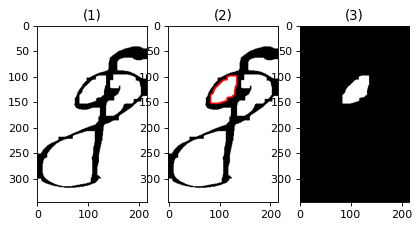

10732.5 660.519855417254
4307.5 660.519855417254


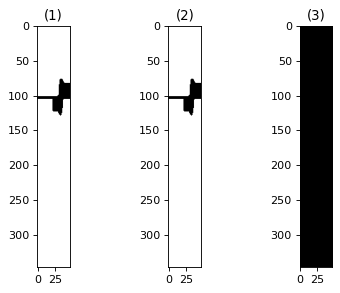

8789.0 660.519855417254
331.0 660.519855417254
1911.5 660.519855417254
848.0 660.519855417254
1641.0 660.519855417254
641.5 660.519855417254
7256.0 660.519855417254


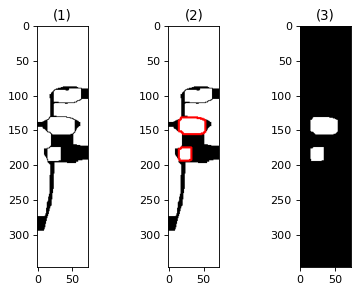

8280.0 660.519855417254
422.0 660.519855417254
8733.0 660.519855417254


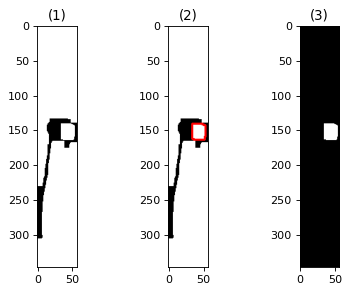

13049.5 660.519855417254
966.5 660.519855417254
28.0 660.519855417254
2963.5 660.519855417254


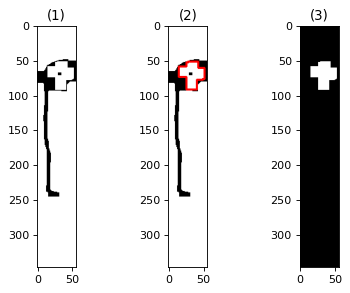

35972.0 660.519855417254
52269.0 660.519855417254


KeyboardInterrupt: 

In [113]:
note_heads_contours = []
i = 0
for lm, dts in zip(list_of_notes_masked, list_of_notes_staff_lines_d_t):
    note_heads_contours.append([])
    for m, dt in zip(lm, dts):
        c = get_note_heads_contours(m, distance_between_staves, staff_thickness)
        note_heads_contours[i].append(c)
    
    i += 1

8206.5 660.519855417254
189.0 660.519855417254
19453.0 660.519855417254
1822.0 660.519855417254
3401.0 660.519855417254
1612.5 660.519855417254
323.5 660.519855417254
29340.5 660.519855417254


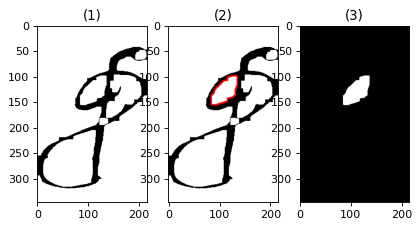

10721.0 660.519855417254
4481.5 660.519855417254


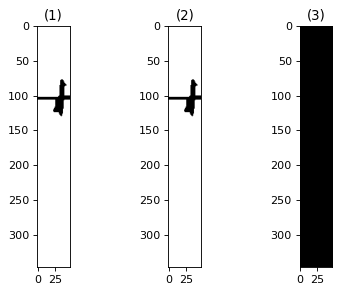

8649.5 660.519855417254
207.0 660.519855417254
400.0 660.519855417254
920.5 660.519855417254
1877.0 660.519855417254
722.0 660.519855417254
9481.5 660.519855417254


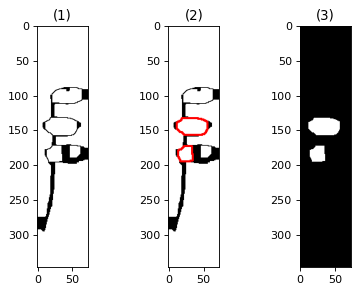

8108.0 660.519855417254
832.5 660.519855417254
8983.0 660.519855417254


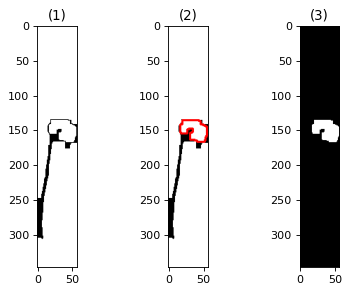

13042.5 660.519855417254
1122.5 660.519855417254
26.5 660.519855417254
3067.5 660.519855417254


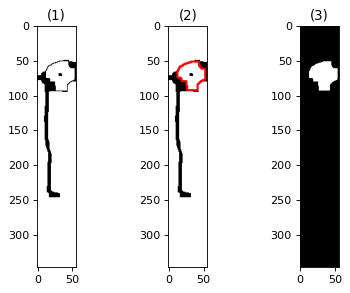

234.5 660.519855417254
220.0 660.519855417254
190.0 660.519855417254
1091.5 660.519855417254
255.0 660.519855417254
110.0 660.519855417254
309.5 660.519855417254
169.0 660.519855417254
36053.0 660.519855417254
263.5 660.519855417254
52652.5 660.519855417254


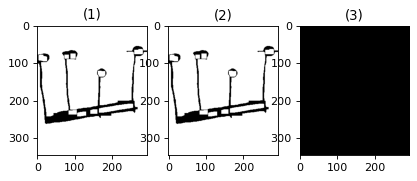

547.5 660.519855417254
379.5 660.519855417254
277.5 660.519855417254
119.0 660.519855417254
52930.0 660.519855417254
727.0 660.519855417254
146.5 660.519855417254
24988.0 660.519855417254


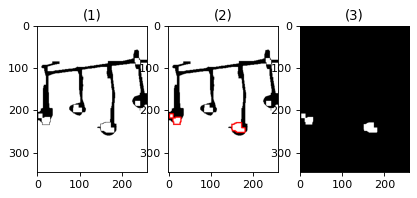

561.5 660.519855417254
14573.0 660.519855417254
1311.5 660.519855417254
10215.5 660.519855417254


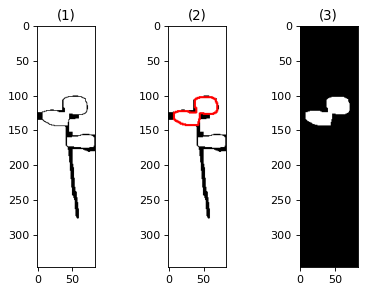

740.0 660.519855417254
20942.0 660.519855417254


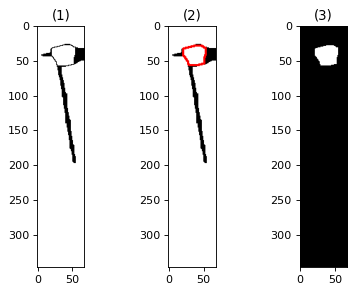

6714.5 660.519855417254
978.0 660.519855417254
52.0 660.519855417254
6520.0 660.519855417254


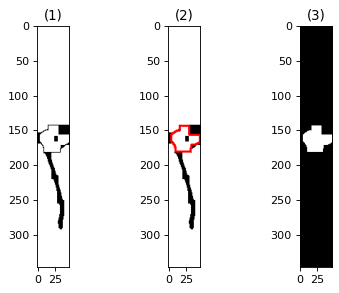

786.0 660.519855417254
18991.0 660.519855417254


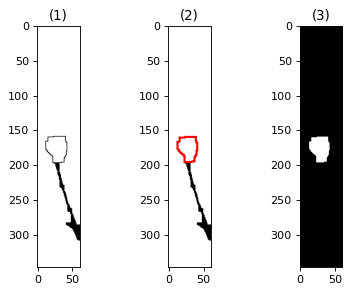

42876.5 660.519855417254


KeyboardInterrupt: 

In [121]:
for m in list_of_notes_masked[1]:
    c = get_note_heads_contours(m, distance_between_staves, staff_thickness)
    #note_heads_contours[i].append(c)

# getting an output

In [27]:
list_of_lines_of_classes = []
for line in list_of_notes_classification_ready:
    features = extract_features_for_all(line, 'hog')
    list_of_lines_of_classes.append(model.predict(features))

# get final output
print("get final output")
output = []
for i,line in enumerate(list_of_lines_of_classes):
    line_output = []
    for j,obj in enumerate(line):
        obj_output = ""
        if check_for_char[obj] :
            is_upper = upper[obj]
            obj_output+=get_letter(list_of_notes_staff_lines_classification_ready[i][j],list_of_notes_classification_ready_contours[i][j],distance_between_staves,is_upper)
        obj_output += corresponding_text[obj]

        line_output.append(obj_output)
    output.append(list(reversed(line_output)))  # ----------------------------- remove reversed if shubra fixes the problem ----------


100%|██████████| 13/13 [00:00<00:00, 1407.85it/s]
get final output


KeyError: 'bar_line_thick'

In [25]:
for i in range(len(binary_lines))
    my_show_images([binary_lines[i]])
    print(output[i])
#my_show_images(list_of_notes_classification_ready[0])



SyntaxError: invalid syntax (<ipython-input-25-6141e1c217d3>, line 1)

In [226]:
print(binary_lines[0].shape)

(406, 4012)


In [230]:
def get_fucking_output(img):
    #load classifier
    target_img_size = (32, 32)
    with open('svm.pkl', 'rb') as fid:
        model = pickle.load(fid)
        
    #get seperate lines
    print("get seperate lines")
    gray_lines, binary_lines, distance_between_staves, staff_thickness = get_lines(img)
    
    #get shubra lines
    print("get shubra lines")
    potential_lines_of_notes = []
    for i in range(len(gray_lines)):
        potential_lines_of_notes.append(getNotes(gray_lines[i] ,binary_lines[i]))
        
        
    # remove staff lines
    print("remove staff lines")
    list_of_notes = []
    list_of_notes_staff_lines = []
    for i, l in enumerate(potential_lines_of_notes):
        list_of_notes.append([])
        list_of_notes_staff_lines.append([])
        for _note in l:
            if _note.shape[1] >= 30:
                staff_lines_removed, staff_lines = remove_staff_lines(_note, staff_thickness)
                if (staff_lines_removed > 128).any():
                    list_of_notes[i].append(staff_lines_removed)
                    list_of_notes_staff_lines[i].append(staff_lines)
    
    
    #zoom in
    print("zoom in")
    list_of_notes_classification_ready = []
    list_of_notes_staff_lines_classification_ready = []
    list_of_notes_classification_ready_contours = []

    i = 0
    for line_of_notes, line_notes_staff_lines in zip(list_of_notes, list_of_notes_staff_lines):
        list_of_notes_classification_ready.append([])
        list_of_notes_staff_lines_classification_ready.append([])
        list_of_notes_classification_ready_contours.append([])

        for note, sl in zip(line_of_notes, line_notes_staff_lines):
            notes, staff_lines, notes_contours = zoom_in(note, sl)
            for n, s, c in zip(notes, staff_lines, notes_contours):
                n = add_padding(n, ww=int(n.shape[1]*2.5), hh=int(n.shape[0]*1.5), color=0)
                list_of_notes_classification_ready[i].append(n)
                list_of_notes_staff_lines_classification_ready[i].append(s)
                list_of_notes_classification_ready_contours[i].append(c)

        i += 1

    list_of_lines_of_classes = []
    for line in list_of_notes_classification_ready:
        features = extract_features_for_all(line, 'hog')
        list_of_lines_of_classes.append(model.predict(features))
    
    # get final output
    print("get final output")
    output = []
    for i,line in enumerate(list_of_lines_of_classes):
        line_output = []
        for j,obj in enumerate(line):
            obj_output = ""
            if check_for_char[obj] :
                is_upper = upper[obj]
                obj_output+=get_letter(list_of_notes_staff_lines_classification_ready[i][j],list_of_notes_classification_ready_contours[i][j],distance_between_staves,is_upper)
            obj_output += corresponding_text[obj]
            
            line_output.append(obj_output)
        output.append(list(reversed(line_output))) # ----------------------------- remove reversed if shubra fixes the problem ---------------------------
    
    return output

In [231]:
print(get_fucking_output(img))

C:\Users\youssef mahmoud\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator LinearSVC from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


get seperate lines
get shubra lines
remove staff lines
zoom in


100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1872.57it/s]


get final output
[['', 'f1/2', '', 'c2/4', 'c1/2', '#', 'c1/2', 'f1/4', '&&', 'f1/4', '', 'f1/4', '#', 'e2/4', '.', '.', '', 'b1/32', '.', 'e1/4', 'e1/1'], ['', 'g1/2', 'd2/2', 'a2/32', 'e2/4', '\\meter<"4/4">', '#', 'c1/8', 'c1/4', 'a1/4', 'f1/4', 'd1/32', 'e1/8', 'f1/4', 'g2/4', 'f1/4', 'e1/4', 'e1/32'], ['e2/2', '', '', 'd1/2', 'd1/32', 'd1/8', 'd1/16', 'd1/32', 'f2/16', 'c1/2', 'b1/4', 'c1/32', '\\meter<"4/4">', 'g1/32', 'e1/32']]
